# Use PVLIB to convert Himwari irradiance to PV output

In [2]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import os

import sys
sys.path.append('/home/548/cd3022/aus-historical-solar-droughts/code/python/scripts')
import utils_V2

import xarray as xr

In [3]:
dataset = utils_V2.get_irradiance_day(resolution='p1h', day='10-2-2017')

In [22]:
# apply REZ mask to data, removes spatial regions note relevant to solar PV gen
mask_file = "/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/REZ_mask.npz"
loaded_mask = np.load(mask_file)
mask = loaded_mask["mask"]
mask_da = xr.DataArray(mask, coords={"latitude": dataset.latitude, "longitude": dataset.longitude}, dims=["latitude", "longitude"])
masked_ds = dataset.where(mask_da, drop=True)

In [27]:
rest = masked_ds.reindex_like(dataset)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/a

In [9]:
# REZ_ghi = dataset['hourly_integral_of_surface_global_irradiance']
# REZ_dni = dataset['hourly_integral_of_direct_normal_irradiance']
# REZ_dhi = dataset['hourly_integral_of_surface_diffuse_irradiance']

# REZ_ghi = dataset.stack(points=("latitude", "longitude")).dropna("points").values
# REZ_dni = dataset.stack(points=("latitude", "longitude")).dropna("points").values
# REZ_dhi = dataset.stack(points=("latitude", "longitude")).dropna("points").values

In [34]:
# lat = dataset.variables['latitude'][:]
# lon = dataset.variables['longitude'][:]
# lon_grid, lat_grid = np.meshgrid(lon, lat)
# lon_grid = lon_grid[mask]
# lat_grid = lat_grid[mask]

lat = masked_ds.latitude
lon = masked_ds.longitude
lon_grid, lat_grid = np.meshgrid(lon, lat)
# repeat lat/lon grid for each time step
lat_grid_3d = np.repeat(lat_grid.ravel(), dataset.sizes["time"])
lon_grid_3d = np.repeat(lon_grid.ravel(), dataset.sizes["time"])

In [3]:
# # get himawari data

# year = '2020'
# month = '03'
# day = '20'
# utc = '0400'
# datein=year+month+day+utc
# maxv=225
# filename='IDE00326.'+datein+'.nc'

# dirin='/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/'+datein[0:4]+'/'+datein[4:6]+'/'+datein[6:8]+'/'

# # dataset = Dataset(dirin+filename)
# dataset = xr.open_dataset(dirin+filename)

# # Read the variables
# lat = dataset.variables['latitude'][:]
# lon = dataset.variables['longitude'][:]
# lon_grid, lat_grid = np.meshgrid(lon, lat)
# lon_grid = lon_grid[mask]
# lat_grid = lat_grid[mask]

# REZ_ghi = dataset['surface_global_irradiance'].squeeze(dim="time").where(mask)
# REZ_dni = dataset['direct_normal_irradiance'].squeeze(dim="time").where(mask)
# REZ_dhi = dataset['surface_diffuse_irradiance'].squeeze(dim="time").where(mask)

# REZ_ghi = REZ_ghi.stack(points=("latitude", "longitude")).dropna("points").values
# REZ_dni = REZ_dni.stack(points=("latitude", "longitude")).dropna("points").values
# REZ_dhi = REZ_dhi.stack(points=("latitude", "longitude")).dropna("points").values

In [16]:
# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

# temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

surface_azimuth = 0

surface_tilt = -lat_grid.ravel()

In [19]:
# # time = pd.Timestamp(f'{year}-{month}-{day} {utc[0:2]}:{utc[2:4]}:00', tz='UTC')
# # time_array = np.full_like(lon_grid, time, dtype=object)

# # Define PV system (fixed tilt)
# system = {
#     'module': module,
#     'inverter': inverter,
#     'surface_azimuth': surface_azimuth,
#     'surface_tilt': surface_tilt
# }

In [20]:
# Compute solar position for all grid cells at once
solpos = pvlib.solarposition.get_solarposition(
    dataset.time,
    lat_grid.ravel(),
    lon_grid.ravel()
)

ValueError: operands could not be broadcast together with shapes (17,) (151804,) 

In [7]:
# Find the angle of incidence
aoi = pvlib.irradiance.aoi(
    surface_tilt=surface_tilt.data,
    surface_azimuth=surface_azimuth,
    solar_zenith=solpos["apparent_zenith"],
    solar_azimuth=solpos["azimuth"],
)

In [8]:
# Compute air mass
airmass_relative = pvlib.atmosphere.get_relative_airmass(
    solpos['apparent_zenith'].values
)
airmass_absolute = pvlib.atmosphere.get_absolute_airmass(
    airmass_relative,
)

total_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt.data,
    surface_azimuth=surface_azimuth,
    dni=REZ_dni.ravel(),
    ghi=REZ_ghi.ravel(),
    dhi=REZ_dhi.ravel(),
    solar_zenith=solpos['apparent_zenith'].values,
    solar_azimuth=solpos['azimuth'].values
)

effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
    poa_direct=total_irradiance['poa_direct'],
    poa_diffuse=total_irradiance['poa_diffuse'],
    airmass_absolute=airmass_absolute,
    aoi=aoi,
    module=module,
)
effective_irradiance_QC = effective_irradiance.clip(lower=0)

# Compute power
dc = pvlib.pvsystem.sapm(
    effective_irradiance=effective_irradiance_QC,
    temp_cell=np.full_like(effective_irradiance, 18), # assume temperature of 18 deg C
    module=module
)

ac = pvlib.inverter.sandia(
    v_dc=dc['v_mp'],
    p_dc=dc['p_mp'],
    inverter=inverter
)
ac_QC = np.where(ac < 0, np.nan, ac)
ac_aus = ac_QC.reshape(lat_grid.shape)
rated_capacity = module.loc['Impo'] * module.loc['Vmpo']
cf = ac_aus/rated_capacity

In [9]:
cf_reshaped = np.full(mask.shape, np.nan)  # Initialize full grid with NaNs
cf_reshaped[mask] = cf  # Assign values back

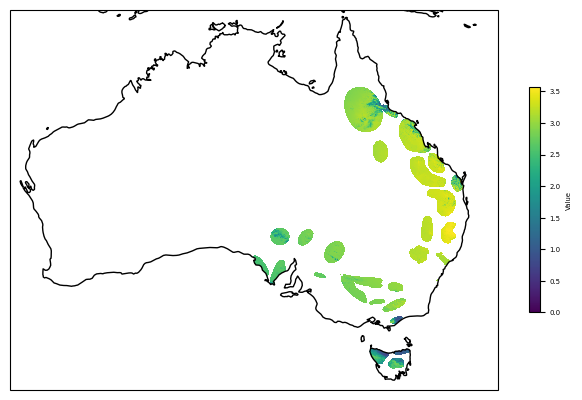

In [29]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

mesh=ax.pcolormesh(lon, lat, y, cmap='viridis',vmin=0, transform=ccrs.PlateCarree())

ax.coastlines()
cbar = plt.colorbar(mesh,ax=ax,shrink=0.5)
cbar.ax.tick_params(labelsize=5)  # Set the font size for the colorbar ticks
cbar.set_label('Value', fontsize=5) 
 
plt.tight_layout()

plt.show()

In [11]:
cf = ac_aus/rated_capacity

In [12]:
# verify rated capacity
dc_MAX = pvlib.pvsystem.sapm(
    effective_irradiance=1000,
    temp_cell=25,
    module=module
)

dc_MAX['p_mp'] / rated_capacity

1.0000002

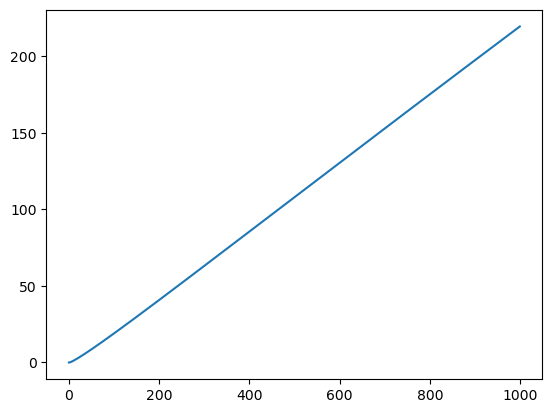

In [13]:
dc_out = []
for rad in range(1000):
    dc = pvlib.pvsystem.sapm(
        effective_irradiance=rad,
        temp_cell=25,
        module=module
    )
    dc_out.append(dc['p_mp'])
plt.plot(dc_out)

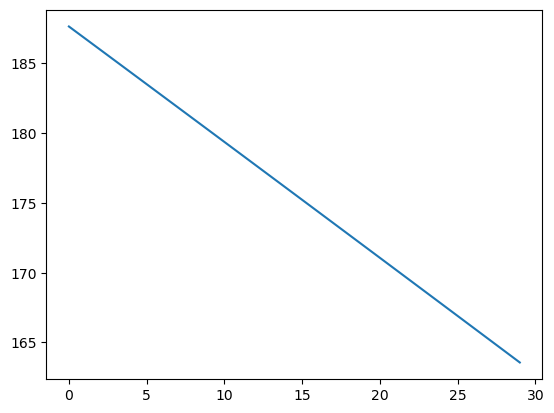

In [14]:
dc_out = []
for temp in range(10,40):
    dc = pvlib.pvsystem.sapm(
        effective_irradiance=800,
        temp_cell=temp,
        module=module
    )
    dc_out.append(dc['p_mp'])
plt.plot(dc_out)